In [1]:
!pip install tensorflow_decision_forests
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00


In [3]:
import os
import json
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 1000)
import matplotlib.pyplot as plt
import tensorflow_decision_forests as tfdf
import keras_tuner as kt
from sklearn.datasets import load_iris

# Google Course Summary

*   A decision tree is a model composed of a collection of conditions organized hierarchically in the shape of a tree. Conditions fall into various categories:
> 1. An axis-aligned condition involves only a single feature. An oblique condition involves multiple features.
> 2. A binary condition has two possible outcomes. A non-binary condition has more than two possible outcomes.
* Training a decision tree involves searching for the best condition at each node. The splitter routine uses metrics such as information gain or Gini to determine the best condition.
* A decision forest is a mode made of multiple decision trees. The prediction of a decision forest is the aggregation of the predictions of its decision trees.
* A random forest is an ensemble of decision trees in which each decision tree is trained with a specific random noise.
* Bagging is a technique in which each decision tree in the random forest is trained on a different subset of examples.
* Random forests do not require a validation dataset. Instead, most random forests use a technique called out-of-bag-evaluation to evaluate the quality of the model.
* A gradient boosted (decision) tree is a type of decision forest trained through iterative adjustments from input decision trees. A value called shrinkage controls the rate at which a gradient boosted (decision) tree learns and the degree to which it could overfit.

# **Classification** - IRIS Flowers
---
150 examples from 3 balenced (50/50/50) classes

> Features (sepal length, sepal width, petal length, petal width)

> Target Class (Iris setosa, Iris versicolor, or Iris virginica)
---
## Dataset Considerations
* Target Classes 1 & 2 are non-linearly seperable but both are linearly sperable from Class 0
* A single class predictor has 33% accuracy
* A robust evaluation should have a careful test-train split that is not imbalenced on Class 0



In [4]:
label = "target"
X, y = load_iris(as_frame=True, return_X_y=True)
dataset = X.join(y)
print("Classes are balenced ", y.value_counts(), sep="\n")

Classes are balenced 
0    50
1    50
2    50
Name: target, dtype: int64


In [5]:
for df in [dataset[dataset[label] == i] for i in [0,1,2]]: print(df.describe().to_string(), end="\n\n")

       sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  target
count           50.00000         50.000000          50.000000         50.000000    50.0
mean             5.00600          3.428000           1.462000          0.246000     0.0
std              0.35249          0.379064           0.173664          0.105386     0.0
min              4.30000          2.300000           1.000000          0.100000     0.0
25%              4.80000          3.200000           1.400000          0.200000     0.0
50%              5.00000          3.400000           1.500000          0.200000     0.0
75%              5.20000          3.675000           1.575000          0.300000     0.0
max              5.80000          4.400000           1.900000          0.600000     0.0

       sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  target
count          50.000000         50.000000          50.000000         50.000000    50.0
mean            5.936000       

Examining statistics on features split by label class, target classes 1 & 2 are non-linearly seperable but both are linearly sperable from class 0.

# Data Split

training ~80%, test ~20%

Want traing and test splits to be representative of the total dataset so aiming for mean 1 std 0.81

In [6]:
np.random.seed(5)
# Use the ~25% of the examples as the testing set
# and the remaining ~75% of the examples as the training set.
test_indices = np.random.rand(len(dataset)) < 0.25
pd_train_dataset = dataset[~test_indices]
pd_test_dataset = dataset[test_indices]

print("Training examples: ", len(pd_train_dataset))
print(pd_train_dataset[label].describe())

print("\nTesting examples: ", len(pd_test_dataset))
print(pd_test_dataset[label].describe())


Training examples:  111
count    111.0000
mean       1.0000
std        0.8202
min        0.0000
25%        0.0000
50%        1.0000
75%        2.0000
max        2.0000
Name: target, dtype: float64

Testing examples:  39
count    39.00000
mean      1.00000
std       0.82717
min       0.00000
25%       0.00000
50%       1.00000
75%       2.00000
max       2.00000
Name: target, dtype: float64


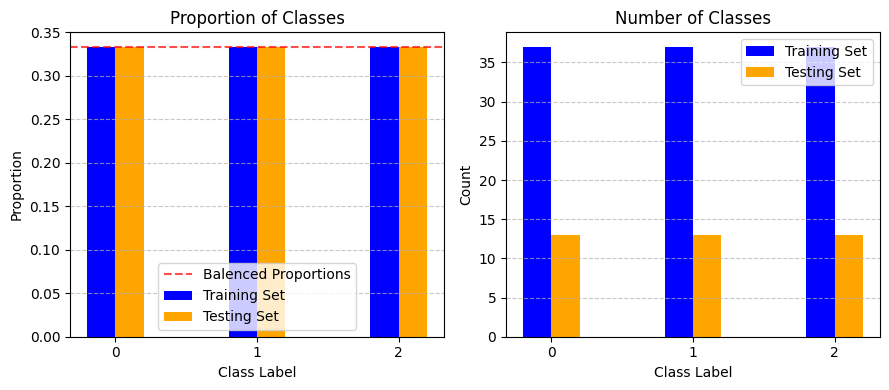

In [7]:
# Calculate class proportions and counts
class_proportions_train = pd_train_dataset[label].value_counts(normalize=True, sort=False)
class_proportions_test = pd_test_dataset[label].value_counts(normalize=True, sort=False)

class_counts_train = pd_train_dataset[label].value_counts(normalize=False, sort=False)
class_counts_test = pd_test_dataset[label].value_counts(normalize=False, sort=False)

# Create the plot with consistent bar width
plt.figure(figsize=(9, 4))

# Subplot 1: Proportions
plt.subplot(121)
plt.bar([0,1,2], class_proportions_train.values, width=0.2, label='Training Set', color='blue')
plt.bar([0.2,1.2,2.2], class_proportions_test.values, width=0.2, label='Testing Set', color='orange')
plt.axhline(y=0.333333,linestyle='--', alpha = 0.7, color = 'red', label = "Balenced Proportions")
plt.xticks([0.1,1.1,2.1], [0, 1, 2], rotation=0)  # Adjusted xticks
plt.title("Proportion of Classes")
plt.xlabel("Class Label")
plt.ylabel("Proportion")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Subplot 2: Counts
plt.subplot(122)
plt.bar([0, 1, 2], class_counts_train.values, width=0.2, label='Training Set', color='blue')
plt.bar([0.2, 1.2, 2.2], class_counts_test.values, width=0.2, label='Testing Set', color='orange')
plt.xticks([0.1,1.1,2.1], [0, 1, 2], rotation=0)  # Adjusted xticks
plt.title("Number of Classes")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

The training test splits are statiscially simular

In [8]:
tf_train_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(pd_train_dataset, label=label)
tf_test_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(pd_test_dataset, label=label)

# Model 1: Decision Tree

In [46]:
base_model = tfdf.keras.CartModel(random_seed=1)
base_model.compile("accuracy")
base_model.fit(tf_train_dataset)
print("Base Model: ", base_model.evaluate(tf_test_dataset, return_dict=True))
tfdf.model_plotter.plot_model_in_colab(base_model, max_depth=10)

Use /tmp/tmp1ojq2stz as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.576315. Found 111 examples.
Training model...
Model trained in 0:00:00.034767
Compiling model...
Model compiled.
1/1 [==============================] - 0s 362ms/step - loss: 0.0000e+00 - accuracy: 0.9231
Base Model:  {'loss': 0.0, 'accuracy': 0.9230769276618958}


With default hyperameter Settings, observe accuracy of 92.3%
This sets a baseline model to improve upon with a hyperameter gridsearch.

[]

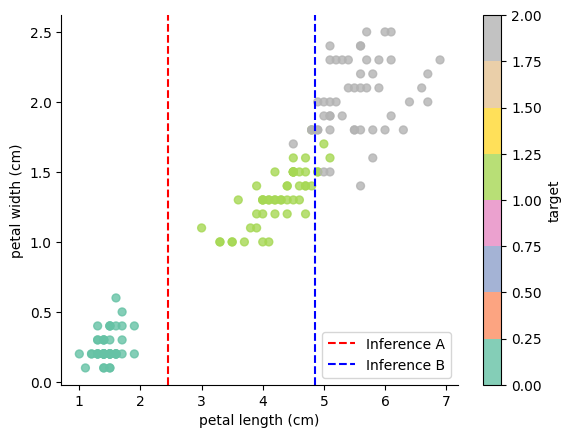

In [47]:
dataset.plot(kind='scatter', x='petal length (cm)', y='petal width (cm)', c='target', cmap="Set2",s=32, alpha=.8)
plt.axvline(x=2.45 , linestyle="--", color="red", label= "Inference A")
plt.axvline(x=4.85 , linestyle="--", color="blue", label="Inference B")
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.legend()
plt.plot()

Because DTs are so interpreble we can observe the inferences of the baseline model in feature space. Because this model makes use of just 1 feauture, it can be plotted on just a number line but petal width here gives a sense of how class 1 and 2 are non-linearly seperable

In [38]:
def build_CART_model(hp):
  model = tfdf.keras.CartModel(
      random_seed = 1,
      sorting_strategy="IN_NODE",
      min_examples=hp.Choice("min_examples",
        # min_examples for creating a leaf node, forcing tree to be deeper when small
        [1, 3, 5, 8]),

      validation_ratio=hp.Choice("validation_ratio",
         # disable leaf pruning or use 15% of tr data to prune
         [0.0, 0.15]),

      num_candidate_attributes=hp.Choice("num_candidate_attributes",
        # at each node, 1 candidate features or all features as candidates -
        [1,4]),

      max_depth=hp.Choice("max_depth",
        # limit the depth of the tree - regularise overfit and obtain simple models to visualise infernces
        [3,5,10]),

      split_axis = hp.Choice("split_axis",
       # splitter modes - oblique splits use multiple
       ["AXIS_ALIGNED", "SPARSE_OBLIQUE"])
      )
  model.compile("accuracy")
  return model

tuner = kt.GridSearch(
    build_CART_model,
    objective="val_accuracy",
    directory="/tmp/tuner",
    project_name="Classification_Tree")

tuner.search(x=tf_train_dataset, validation_data=tf_test_dataset, overwrite=True)

Trial 96 Complete [00h 00m 01s]
val_accuracy: 0.9230769276618958

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 01m 57s


In [43]:
base_dir = "/tmp/tuner/Classification_Tree"

model_stats = ["accuracy", "val_ratio", "min_examples", "num_candidate_attributes", "max_depth", "split_axis"]
results = {k: [] for k in model_stats}

for trial_dir in os.listdir(base_dir):
  # Construct the full path to the trial directory
  trial_path = os.path.join(base_dir, trial_dir)
  # Check if it's a directory
  if os.path.isdir(trial_path): # Construct the path to the trail.json file
    json_file_path = os.path.join(trial_path, "trial.json")
    # Check if the file exists
    if os.path.isfile(json_file_path):
        # Open the file and read its contents
        with open(json_file_path, "r") as f:
            data = json.load(f)
            hyperparams = data["hyperparameters"]["values"]
            results["accuracy"].append(data["score"])
            results["val_ratio"].append(hyperparams["validation_ratio"])
            results["min_examples"].append(hyperparams["min_examples"])
            results["num_candidate_attributes"].append(hyperparams["num_candidate_attributes"])
            results["max_depth"].append(hyperparams["max_depth"])
            results["split_axis"].append(hyperparams["split_axis"])

pd.DataFrame(results).sort_values(by="accuracy", ascending=False).head(10)

,accuracy,val_ratio,min_examples,num_candidate_attributes,max_depth,split_axis
56,1.0,0.0,1,4,3,SPARSE_OBLIQUE
65,1.0,0.0,8,4,3,SPARSE_OBLIQUE
73,1.0,0.0,3,4,10,SPARSE_OBLIQUE
23,1.0,0.0,3,4,5,SPARSE_OBLIQUE
57,1.0,0.0,1,1,3,SPARSE_OBLIQUE
18,1.0,0.0,3,1,3,SPARSE_OBLIQUE
79,1.0,0.0,3,1,5,SPARSE_OBLIQUE
82,1.0,0.0,1,1,5,SPARSE_OBLIQUE
67,1.0,0.0,3,4,3,SPARSE_OBLIQUE
26,1.0,0.0,1,4,5,SPARSE_OBLIQUE


Test set small, pick best model from top 5 by highest validation ratio as easier to interpret a smaller tree

Obtained a set of models to evaluate on a larger validation dataset

# Model 2: Random Forest


In [48]:
base_model = tfdf.keras.RandomForestModel()
base_model.compile("accuracy")
base_model.fit(tf_train_dataset)
print("Base Model: ", base_model.evaluate(tf_test_dataset, return_dict=True))

Use /tmp/tmp8tpttbuo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.190619. Found 111 examples.
Training model...
Model trained in 0:00:00.042836
Compiling model...
Model compiled.


1/1 [==============================] - 0s 143ms/step - loss: 0.0000e+00 - accuracy: 0.9744
Base Model:  {'loss': 0.0, 'accuracy': 0.9743589758872986}


In [16]:
def build_RF_model(hp):
  model = tfdf.keras.RandomForestModel(
      random_seed = 1,
      sorting_strategy="IN_NODE",
      min_examples=hp.Choice("min_examples",[5,10]),
      max_depth=hp.Choice("max_depth",[8,10]),
      num_candidate_attributes=hp.Choice("num_candidate_attributes",[1,2,4]),
      num_trees = hp.Choice("num_trees",[512,1024]),
      honest = hp.Boolean("honest"),
      split_axis = hp.Choice("split_axis",
       # splitter modes - oblique splits use multiple features
       ["AXIS_ALIGNED", "SPARSE_OBLIQUE"])
      )
  model.compile("accuracy")
  return model

tuner = kt.GridSearch(
    build_RF_model,
    objective="val_accuracy",
    directory="/tmp/tuner",
    project_name="Random_Forest")

tuner.search(x=tf_train_dataset, validation_data=tf_test_dataset, overwrite=True)

Reloading Tuner from /tmp/tuner/Random_Forest/tuner0.json


In [54]:
# Define the directory to iterate through
base_dir = "/tmp/tuner/Random_Forest"

results = {"accuracy":[], "min_examples":[],"max_depth":[], "num_trees":[], "num_candidate_attributes":[]}

# Iterate through each subdirectory (assuming they represent trials)
for trial_dir in os.listdir(base_dir):
    # Construct the full path to the trial directory
    trial_path = os.path.join(base_dir, trial_dir)
    # Check if it's a directory
    if os.path.isdir(trial_path):
        # Construct the path to the trail.json file
        json_file_path = os.path.join(trial_path, "trial.json")

        # Check if the file exists
        if os.path.isfile(json_file_path):
            # Open the file and read its contents
            with open(json_file_path, "r") as f:
                data = json.load(f)
                hyperparams = data["hyperparameters"]["values"]

                results["accuracy"].append(data["score"])
                results["max_depth"].append(hyperparams["max_depth"])
                results["num_trees"].append(hyperparams["num_trees"])
                results["min_examples"].append(hyperparams["min_examples"])
                results["num_candidate_attributes"].append(hyperparams["num_candidate_attributes"])

pd.DataFrame(results).sort_values(by="accuracy", ascending=False).head(15)

,accuracy,min_examples,max_depth,num_trees,num_candidate_attributes
0,0.974359,1,16,512,2
203,0.974359,5,16,256,4
185,0.974359,1,16,1024,1
187,0.974359,10,16,256,1
188,0.974359,5,16,512,2
189,0.974359,1,8,1024,2
190,0.974359,1,8,1024,2
191,0.974359,1,16,256,1
192,0.974359,5,16,512,4
194,0.974359,1,16,1024,4


In [ ]:
best_model = tfdf.keras.RandomForestModel()
best_model.compile("accuracy")
best_model.fit(tf_train_dataset)
print("Best Model: ", best_model.evaluate(tf_test_dataset, return_dict=True))

# Gradient Boosted Tree

In [9]:
base_model = tfdf.keras.GradientBoostedTreesModel()
base_model.compile("accuracy")
base_model.fit(tf_train_dataset)
print("Base Model: ", base_model.evaluate(tf_test_dataset, return_dict=True))

Use /tmp/tmpy4a9m4vt as temporary training directory
Reading training dataset...
Training dataset read in 0:00:08.323769. Found 111 examples.
Training model...
Model trained in 0:00:00.129683
Compiling model...
Model compiled.
1/1 [==============================] - 0s 431ms/step - loss: 0.0000e+00 - accuracy: 0.9744
Base Model:  {'loss': 0.0, 'accuracy': 0.9743589758872986}


In [ ]:
def build_GBT_model(hp):
  model = tfdf.keras.GradientBoostedTreesModel(
      random_seed = 1,
      sorting_strategy="IN_NODE",
      min_examples=hp.Choice("min_examples",
        # min_examples for creating a leaf node, forcing tree to be deeper when small
        [1, 3, 5, 8]),

      validation_ratio=hp.Choice("validation_ratio",
         # disable leaf pruning or use 15% of tr data to prune
         [0.0, 0.15]),

      num_candidate_attributes=hp.Choice("num_candidate_attributes",
        # at each node, 1 candidate features or all features as candidates -
        [1,4]),

      max_depth=hp.Choice("max_depth",
        # limit the depth of the tree - regularise overfit and obtain simple models to visualise infernces
        [3,5,10]),

      split_axis = hp.Choice("split_axis",
       # splitter modes - oblique splits use multiple
       ["AXIS_ALIGNED", "SPARSE_OBLIQUE"])
      )
  model.compile("accuracy")
  return model

tuner = kt.GridSearch(
    build_GBT_model,
    objective="val_accuracy",
    directory="/tmp/tuner",
    project_name="GBT_Classification")

tuner.search(x=tf_train_dataset, validation_data=tf_test_dataset, overwrite=True)

Trial 35 Complete [00h 00m 03s]
val_accuracy: 0.9743589758872986

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 01m 51s

Search: Running Trial #36

Value             |Best Value So Far |Hyperparameter
3                 |1                 |min_examples
0                 |0.15              |validation_ratio
4                 |1                 |num_candidate_attributes
10                |10                |max_depth
SPARSE_OBLIQUE    |SPARSE_OBLIQUE    |split_axis

Use /tmp/tmp4ordfc_f as temporary training directory


Reading training dataset...
Training dataset read in 0:00:00.200875. Found 111 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(39, shape=(), dtype=int32)
Validation dataset read in 0:00:00.208586. Found 39 examples.
Training model...
